# Introduction
This notebook is to visualize the loss sufraces of different loss functions, and the effect of adding a physics-guided loss term.

### Imports
Import libraries and write settings here.

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import progressbar
import glob
import os
import pandas as pd
import loss_landscapes
import loss_landscapes.metrics

from DNN import DNN
import loss_landscapes
import loss_landscapes.metrics
from config_plots import global_settings
global_settings()
import warnings
warnings.filterwarnings("ignore")
from presets import getPresets
from data_loader import DatasetLoader
from PlotSurfaces import PlotSurfaces, PlotLinearInterpolation
import lossCalculator
from loadModel import LoadModel
from helper import getBxVsCosineSimilarity, getFittedData, GetStatistics, PlotHelper, getFriendlyName

device = torch.device('cpu')
print(device)

cpu


Parameters of the run

In [2]:
dataPath = "../datasets/"
figuresPath = "../figures/"
model_path = "details/"

# Specific to the dataset used. Don't change.
n_spins = 4
trainingCount = 2000
validation_count = 200

# Specific the saved models. Don't change.
H = 100 # Model width
Depth = 3 # Model depth

Load and normalize the data

In [3]:
datasetLoader = DatasetLoader(dataPath, n_spins, trainingCount, validation_count, 0, )
datasetLoader.normalization(x=True, y=False)
datasetLoader.torch_tensor(device=device)

X_train = datasetLoader.X_train_tensor
X_val = datasetLoader.X_val_tensor
X_test = datasetLoader.X_test_tensor
y_train = datasetLoader.y_train_tensor
y_val = datasetLoader.y_val_tensor
y_test = datasetLoader.y_test_tensor
X_scale = datasetLoader.X_scale_tensor
X_mean = datasetLoader.X_mean_tensor
y_scale = datasetLoader.y_scale_tensor
y_mean = datasetLoader.y_mean_tensor
X_trainOrigin = datasetLoader.X_train_origin
X_valOrigin = datasetLoader.X_val_origin
X_testOrigin = datasetLoader.X_test_origin
trainingMag = datasetLoader.tainingMag
testMag = datasetLoader.testMag

# Loss Surface

Parameters

In [4]:
DNN_types=["NN", "PGNN_OnlyDTr", "PGNN_LF", "PGNN_"]

Load the models and experimental results

In [5]:
models = []
lambda_s_trains = []
lambda_s_tests = []
lambda_e_trains = []
lambda_e_tests = []
for DNN_type in DNN_types:
    D_in  = datasetLoader.x_dim
    D_out = datasetLoader.y_dim
    model_final = DNN(D_in, H, D_out, Depth).to(device)

    fullPath = model_path+DNN_type+"_*/models/*.pt"
    files = sorted(glob.glob(fullPath), key=os.path.getmtime)
    numOfEpochs = len(files) -1
    lastModelFile = files[-1]

    if torch.cuda.is_available():
        model_final.load_state_dict(torch.load(lastModelFile))
    else:
        model_final.load_state_dict(torch.load(lastModelFile, map_location='cpu'))

    fullPath = model_path+DNN_type+"_*/results/losses*.csv"
    csv_file = glob.glob(fullPath)[0]
    losses_content = pd.read_csv(csv_file)

    lambda_s_train = losses_content['lambda_s_train']
    lambda_s_test = losses_content['lambda_s_test']
    lambda_e_train = losses_content['lambda_e_train']
    lambda_e_test = losses_content['lambda_e_test']
    
    models.append(model_final)
    lambda_s_trains.append(lambda_s_train)
    lambda_s_tests.append(lambda_s_test)
    lambda_e_trains.append(lambda_e_train)
    lambda_e_tests.append(lambda_e_test)

PLot surfaces

In [6]:
STEPS = 25 # How big the surface section is
DISTANCES=[0.2] # How big each step on the surface section is


plotter = PlotSurfaces(DISTANCES, STEPS, figuresPath)

Plot training MSE surface

Loading projection from disk: saved_landscape_array/NN/0.2/25/Train-MSE.npy
Loading projection from disk: saved_landscape_array/PGNN_OnlyDTr/0.2/25/Train-MSE.npy
Loading projection from disk: saved_landscape_array/PGNN_LF/0.2/25/Train-MSE.npy
Loading projection from disk: saved_landscape_array/PGNN_/0.2/25/Train-MSE.npy


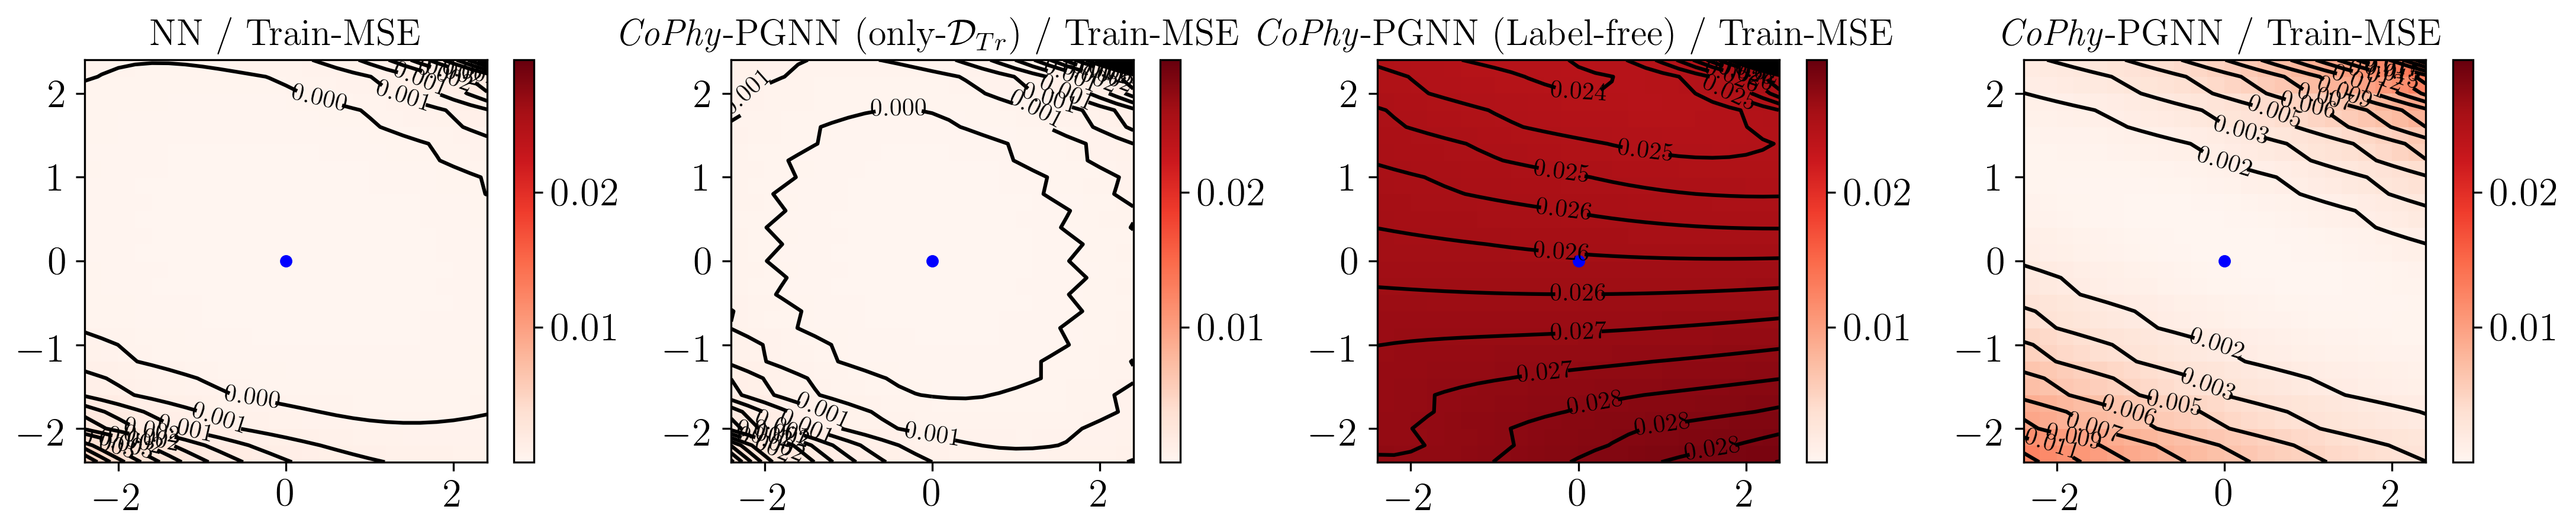

In [7]:
criterion = torch.nn.MSELoss()
metrics = []
for i, DNN_type in enumerate(DNN_types):
    metrics.append(loss_landscapes.metrics.Loss(criterion, X_train.cpu(), y_train.cpu()))

plotter.plotSurfaces(models, DNN_types, metrics, "Train-MSE")

Plot test MSE surface

Loading projection from disk: saved_landscape_array/NN/0.2/25/Test-MSE.npy
Loading projection from disk: saved_landscape_array/PGNN_OnlyDTr/0.2/25/Test-MSE.npy
Loading projection from disk: saved_landscape_array/PGNN_LF/0.2/25/Test-MSE.npy
Loading projection from disk: saved_landscape_array/PGNN_/0.2/25/Test-MSE.npy


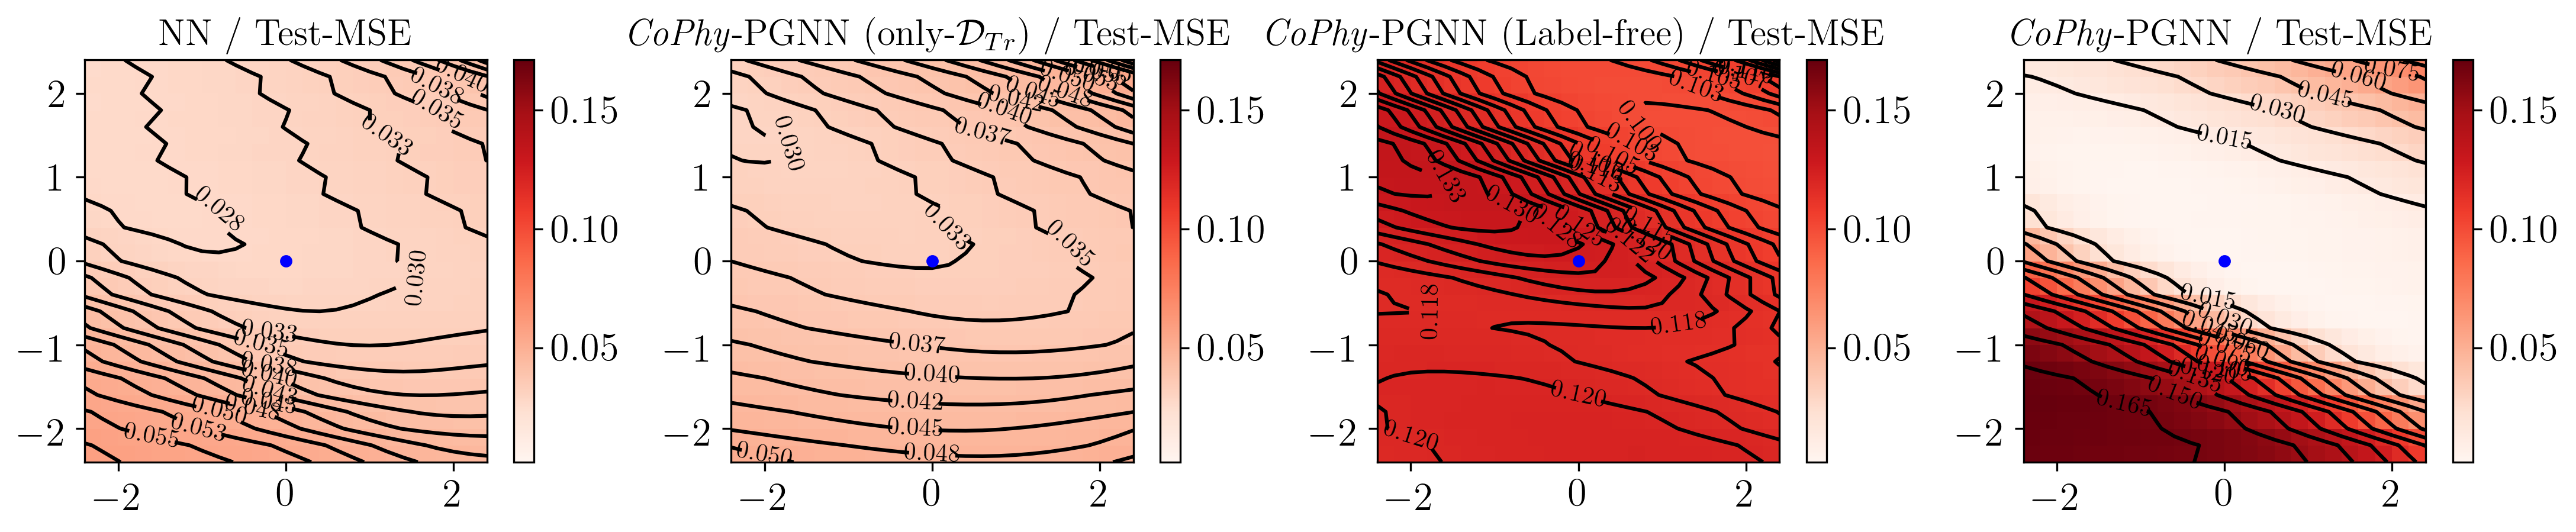

In [8]:
criterion = torch.nn.MSELoss()
metrics = []
for i, DNN_type in enumerate(DNN_types):
    metrics.append(loss_landscapes.metrics.Loss(criterion, X_test.cpu(), y_test.cpu()))

plotter.plotSurfaces(models, DNN_types, metrics, "Test-MSE")

Plot training phy loss surface

In [9]:
class PhyLoss(loss_landscapes.metrics.Loss):
    """ Computes a specified loss function over specified input-output pairs. """
    def __init__(self, i, model, plyloss_fn, inputs: torch.Tensor, target: torch.Tensor, trainH, testH, testInputs=None):
        super().__init__(plyloss_fn, inputs, target)
        self.inputs = inputs
        self.target = target
        self.trainH = trainH
        self.testH = testH
        self.testInputs = testInputs
        self.i = i
        self.model = model

    def __call__(self, model_wrapper) -> float:
        self.inputs.grad = None
        lastElement = len(lambda_e_train) - 1
        e_coff = 0
        s_coff = 0.846
        
        self.predictions = model_wrapper.forward(self.inputs)
        loss_train, loss_phy_train, norm_loss_phy_train, loss_e_train = lossCalculator.loss_func(datasetLoader, ['mse_loss', 'phy_loss', 'energy_loss'], self.predictions, e_coff, s_coff, self.inputs, self.target, self.trainH, norms[self.i])
        loss_test, loss_phy_test, norm_loss_phy_test, loss_e_test = lossCalculator.loss_func(datasetLoader, ['mse_loss', 'phy_loss', 'energy_loss'], self.model(X_test.cpu()), e_coff, s_coff, X_test.cpu(), y_test.cpu(), X_testOrigin.cpu(), norms[self.i])
        mse_train = loss_train - (e_coff*loss_e_train + s_coff*loss_phy_train)
        loss = s_coff*(loss_phy_train + loss_phy_test) + mse_train
        return loss.detach().numpy()


Loading projection from disk: saved_landscape_array/NN/0.2/25/PG-loss.npy
Loading projection from disk: saved_landscape_array/PGNN_OnlyDTr/0.2/25/PG-loss.npy
Loading projection from disk: saved_landscape_array/PGNN_LF/0.2/25/PG-loss.npy
Loading projection from disk: saved_landscape_array/PGNN_/0.2/25/PG-loss.npy


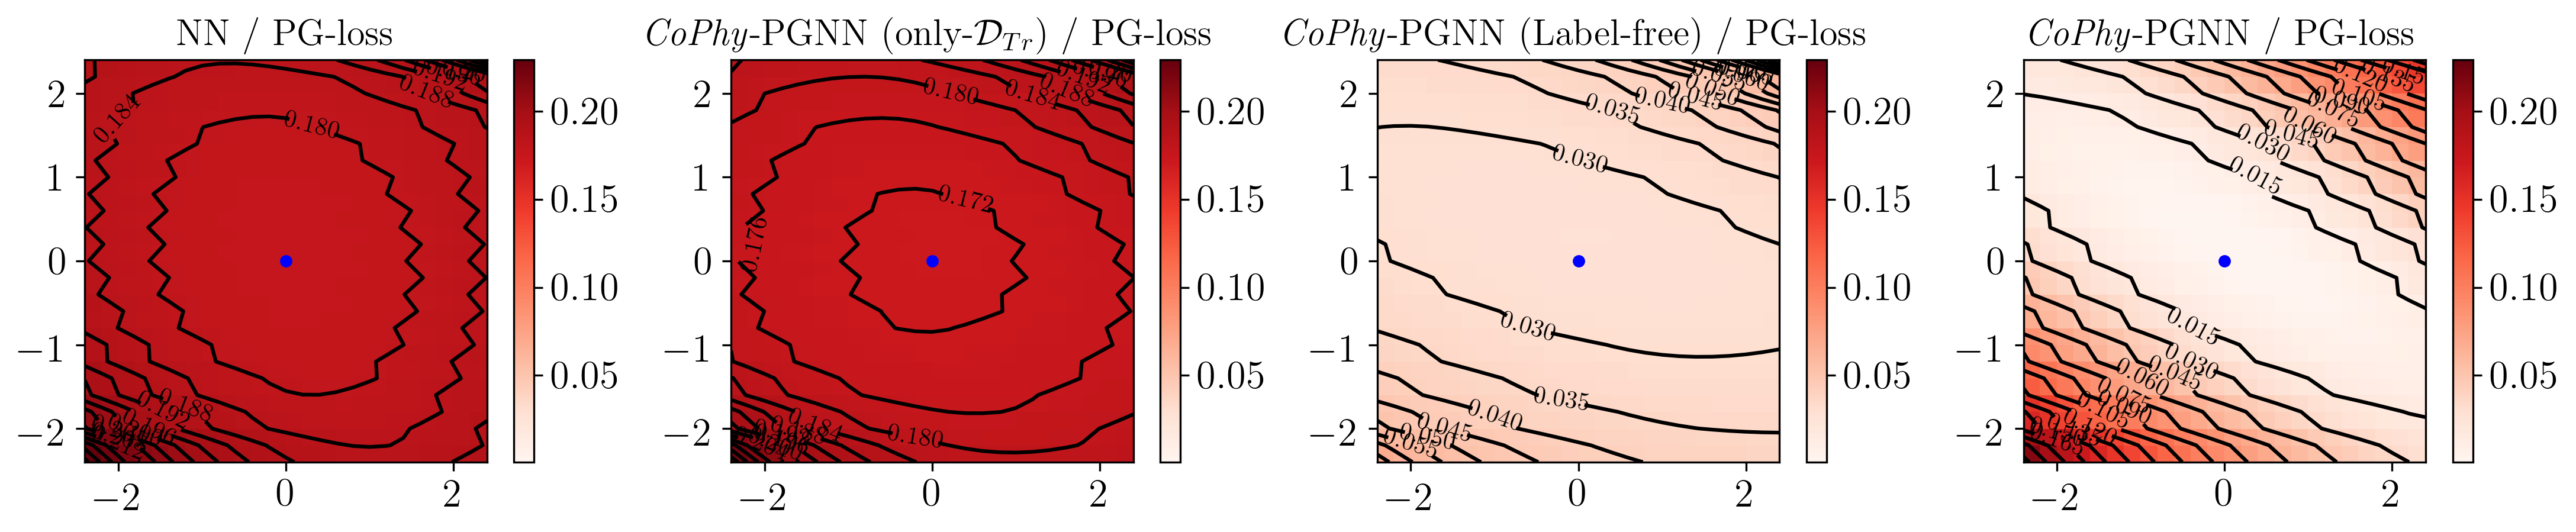

In [10]:
norms = []
for DNN_type in DNN_types:
    (train_loss_list, test_loss_list, norm) = getPresets(DNN_type)
    norms.append(norm)
    
metrics = []
for i, DNN_type in enumerate(DNN_types):
    metrics.append(PhyLoss(i, 
                           models[i], 
                           None, X_train.cpu(), y_train.cpu(), X_trainOrigin.cpu(), None))

plotter.plotSurfaces(models, DNN_types, metrics, "PG-loss")

# Training path on loss surface

Parameters

In [11]:
DNN_type_initial="NN" # usually  DNN_type1 or DNN_type2
DNN_type1="NN"
DNN_type2="PGNN_"

Load models

In [12]:
initialModelUsed = False
if DNN_type_initial == DNN_type1 or DNN_type_initial == DNN_type2:
    initialModelUsed = True

(initialModel, lambda_s_train_initial, lambda_s_test_initial, lambda_e_train_initial, lambda_e_test_initial) = LoadModel(datasetLoader, model_path, DNN_type_initial, H, Depth, device, initialModelUsed)
(model_final1, lambda_s_train1, lambda_s_test1, lambda_e_train1, lambda_e_test1) = LoadModel(datasetLoader, model_path, DNN_type1, H, Depth, device)
(model_final2, lambda_s_train2, lambda_s_test2, lambda_e_train2, lambda_e_test2) = LoadModel(datasetLoader, model_path, DNN_type2, H, Depth, device)
models = []
models.append((DNN_type1, model_final1))
models.append((DNN_type2, model_final2))

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


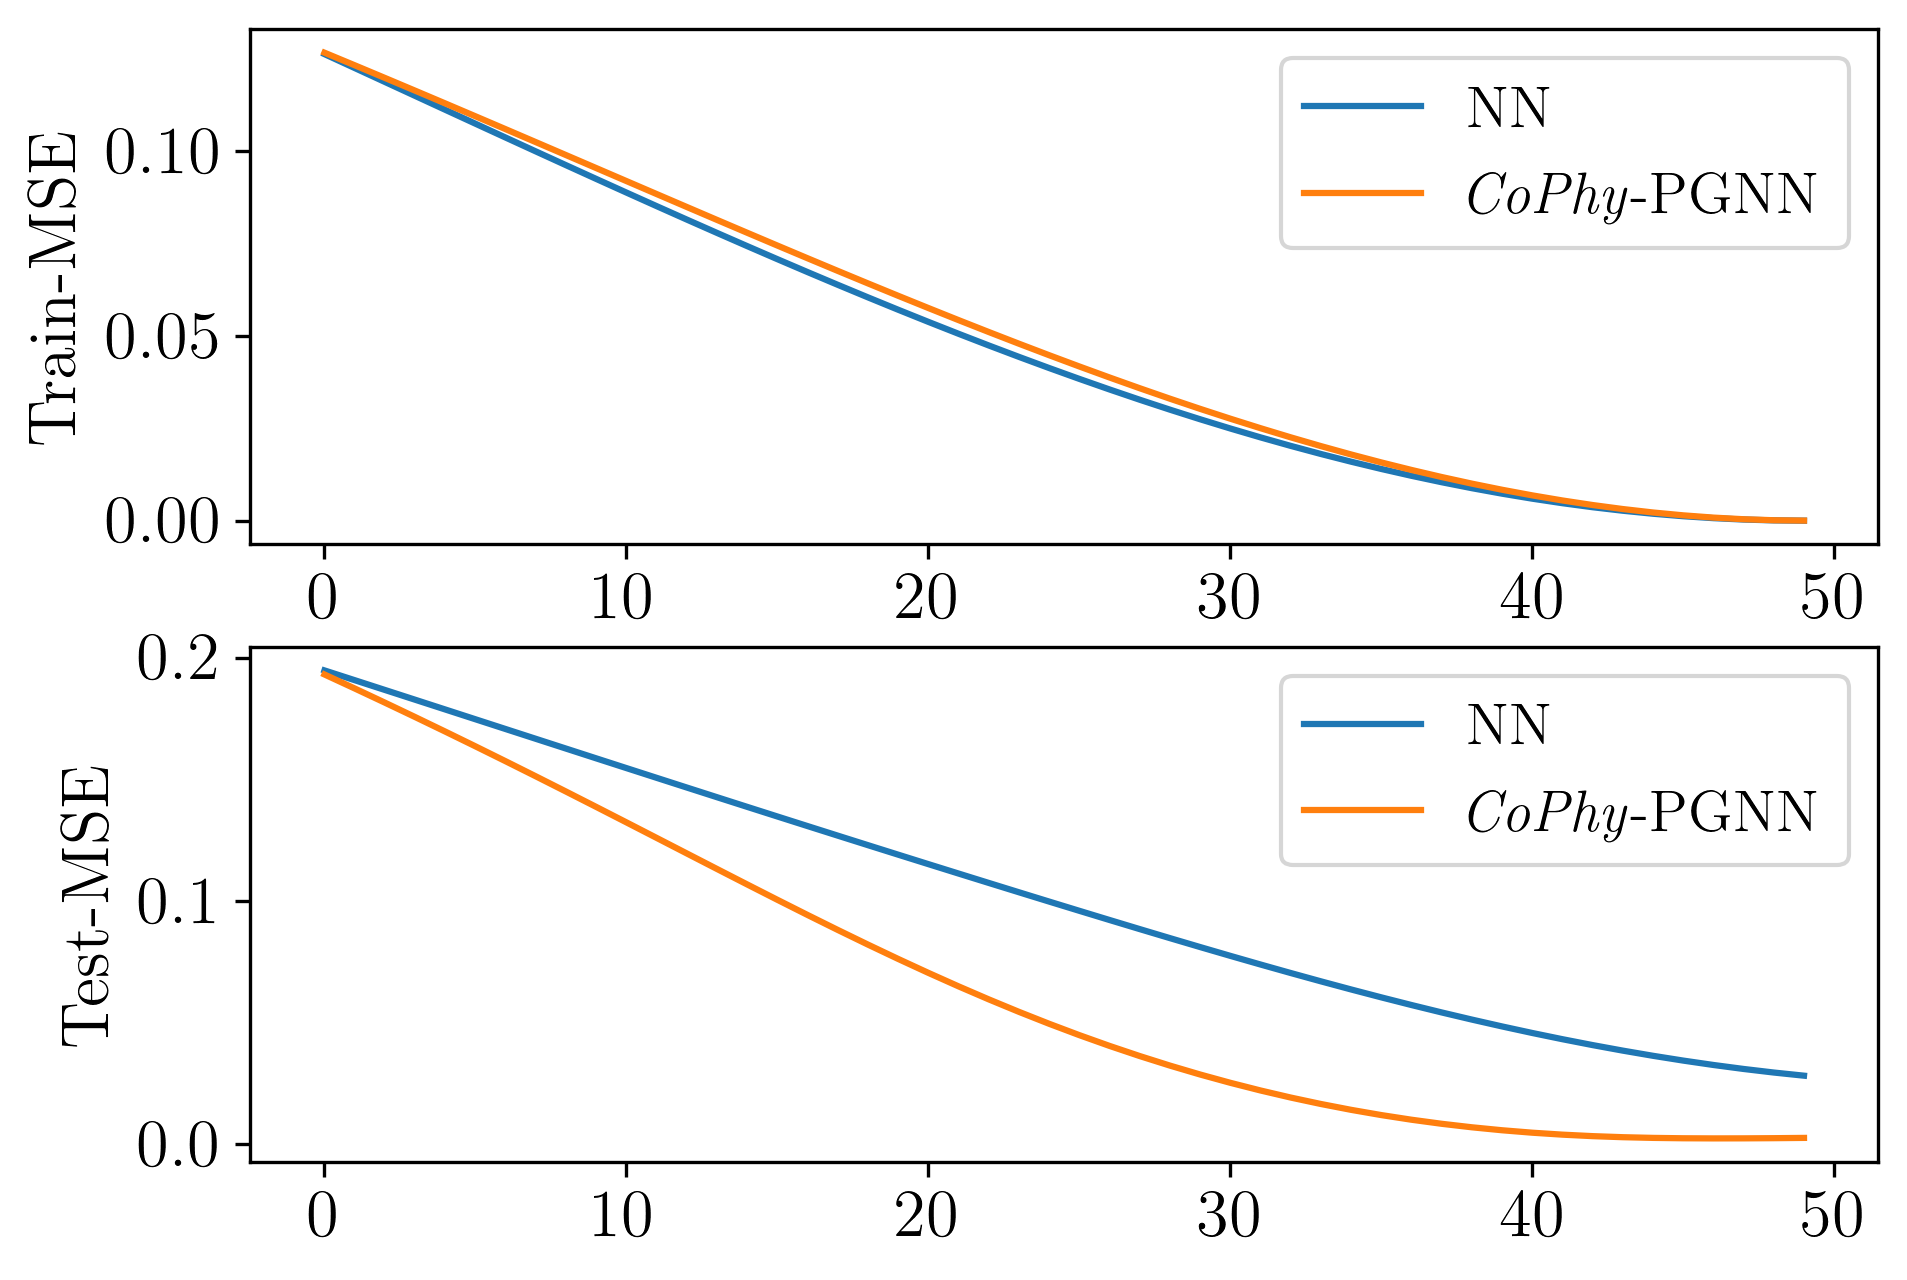

In [13]:
STEPS = 50

fig, axs = plt.subplots(2, figsize=(7, 5), dpi=300)

criterion = torch.nn.MSELoss()
metricTrain = loss_landscapes.metrics.Loss(criterion, X_train, y_train)
metricTest = loss_landscapes.metrics.Loss(criterion, X_test, y_test)

plotter = PlotLinearInterpolation(initialModel, models)
plotter.plotLinearInterpolation(metricTrain, "Train-MSE", 0, axs, STEPS)
plotter.plotLinearInterpolation(metricTest, "Test-MSE", 1, axs, STEPS)

fig.show()
fig.savefig(os.path.join(figuresPath, "1D_"+models[0][0]+"-"+models[1][0]+".pdf"), bbox_inches='tight')   

# Cosine Similarity

Parameters

In [14]:
DNN_types=["NN", "PGNN_OnlyDTr", "PGNN_LF", "PGNN_"]
model_path = "details/10Models/"

Load models

In [15]:
Bx_vs_cosineSimilarity_mean_list = []
Bx_vs_cosineSimilarity_std_list = []
test_x = np.arange(torch.min(testMag), torch.max(testMag), 0.01)

D_in  = datasetLoader.x_dim
D_out = datasetLoader.y_dim
for DNN_type in DNN_types:
    fileList = glob.glob(model_path+DNN_type+"/*.pt")
    
    Bx_vs_cosineSimilarity_list = list()
    for file in fileList:
        model_final = DNN(D_in, H, D_out, Depth).to(device)

        model_final.load_state_dict(torch.load(file, map_location='cpu'))

        Bx_vs_cosineSimilarity = getBxVsCosineSimilarity(testMag, model_final(X_test), y_test)
        Bx_vs_cosineSimilarity_list.append(getFittedData(Bx_vs_cosineSimilarity, test_x))
    
    (Bx_vs_cosineSimilarity_mean, Bx_vs_cosineSimilarity_std) = GetStatistics(Bx_vs_cosineSimilarity_list)
    Bx_vs_cosineSimilarity_mean_list.append(Bx_vs_cosineSimilarity_mean)
    Bx_vs_cosineSimilarity_std_list.append(Bx_vs_cosineSimilarity_std)

Plot

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


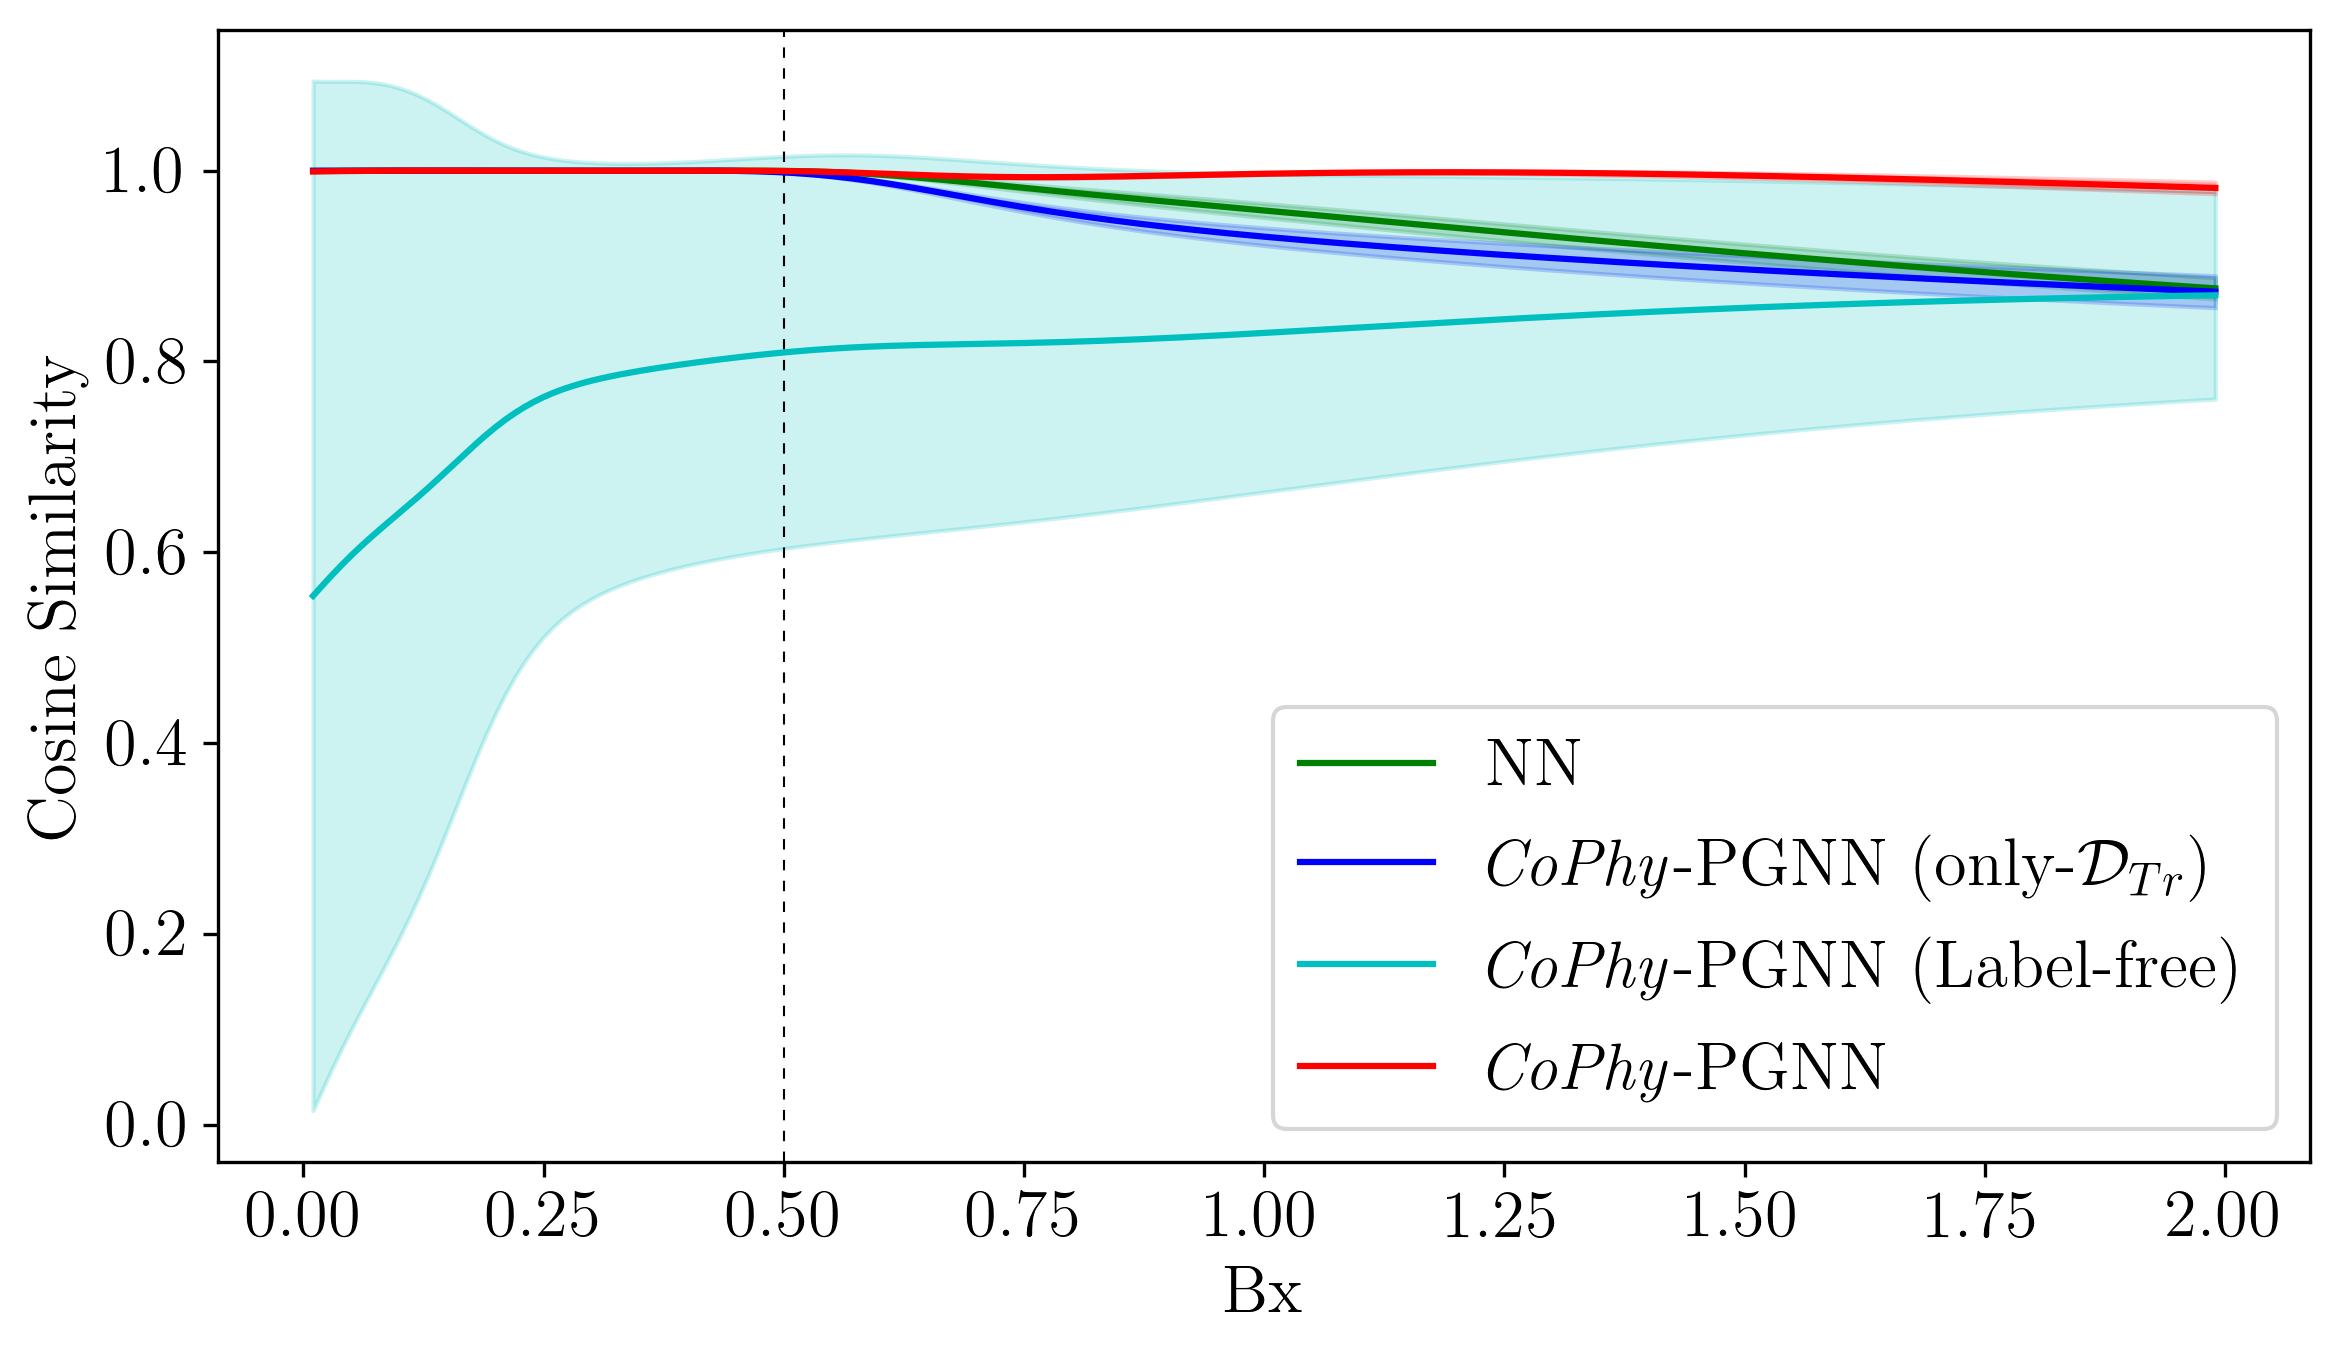

In [16]:
prettyPlot = PlotHelper("Test data Cosine Similarity vs. Bx", "Bx","Cosine Similarity")
for i, DNN_type in enumerate(DNN_types):
    name = getFriendlyName(DNN_type)
    prettyPlot.updatePlotXYSTD(test_x, Bx_vs_cosineSimilarity_mean_list[i], Bx_vs_cosineSimilarity_std_list[i], name, i)
    
prettyPlot.fig.savefig(os.path.join(figuresPath,"CosineSimilarity.pdf"), bbox_inches='tight')